In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TRAINFILE="Data/train.csv"
TESTFILE="Data/test.csv"

#### Import data

In [3]:
trainDf=pd.read_csv(TRAINFILE)
validDf=pd.read_csv(TESTFILE)

In [4]:
keep_cols=['outcome','gender','age','basegrd','baseucva','familyHistory','outdoor','wearGlass',\
            'nearDisPlay','nearDisStudy','nearDisRead','Coarse','seaFood','fruit','vegatables','cookies',\
            'friedFood','soda','basesef']
trainDf=trainDf[keep_cols]
validDf=validDf[keep_cols]

In [5]:
trainDf.dropna(axis=0,how='any',inplace=True)
X,y=trainDf.iloc[:,1:],trainDf.iloc[:,0]

#### Feature selection

In [57]:
# numeric_features = ["age",'baseucva']
# numeric_transformer = Pipeline(
#     steps=[('impute',SimpleImputer(strategy="median"))]
# )
# categorical_features = ["gender", "basegrd", "familyHistory",'outdoor','wearGlass','nearDisPlay','nearDisStudy',\
#     'nearDisRead','Coarse','seaFood','fruit','vegatables','cookies','friedFood','soda','basesef']
# categorical_transformer = Pipeline(
#     steps=[
#         ("impute",SimpleImputer(strategy="most_frequent"))
#     ]
# )
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

In [6]:
categorical_features = ["gender", "basegrd", "familyHistory",'outdoor','wearGlass','nearDisPlay','nearDisStudy',\
     'nearDisRead','Coarse','seaFood','fruit','vegatables','cookies','friedFood','soda','basesef']
X.loc[:,categorical_features]=X.loc[:,categorical_features].astype('object')

In [7]:
cv=StratifiedKFold(10)
#rsf=RandomForestClassifier(random_state=1234)
dtTree=DecisionTreeClassifier(max_depth=8)

In [9]:
# 计算IV值
def cal_IV(X,y,quanList):
    X_copy=X.copy()
    res={}
    noevents,events=np.bincount(y)
    for i,var in enumerate(X_copy.columns.to_list()):
        #print(var)
        iv=0
        if var in quanList:
            try:
                X_copy[var]=pd.qcut(X[var],q=[0,0.25,0.50,0.75,1],duplicates='drop',labels=[1,2,3,4])
            except:
                X_copy[var]=pd.qcut(X[var],q=[0,0.25,0.50,0.75,1],duplicates='drop',labels=[1,2,3])
        uniqueList=np.unique(X_copy[var])
        for value in uniqueList:
            v_events=(y[X_copy[var]==value]==1).sum()
            v_noevents=(y[X_copy[var]==value]==0).sum()
            iv+=(v_events/events-v_noevents/noevents)*np.log((v_events/events)/(v_noevents/noevents))
        res[var]=iv
    return res

ivData=cal_IV(X,y,quanList=['age','baseucva'])

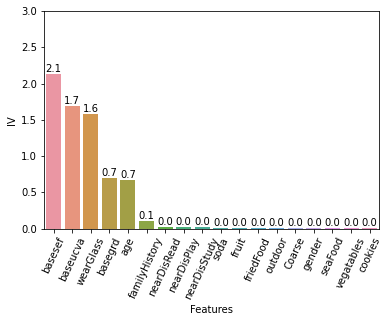

In [10]:
ivData=pd.DataFrame(zip(ivData.keys(),ivData.values()),columns=['Features','IV'])
ivData=ivData.sort_values(by='IV',ascending=False)
ax=sns.barplot(data=ivData,x='Features',y="IV")
ax.set_xticklabels(ax.get_xticklabels(),rotation=65)
for p in ax.patches:
    _x=p.get_x()+p.get_width()/2
    _y=p.get_y()+p.get_height()+0.03
    value='{:.1f}'.format(p.get_height())
    ax.text(_x,_y,value,ha='center')
ax.set_ylim(0,3)
plt.savefig("./Plots/IV.jpg",bbox_inches='tight',dpi=300)